#  Stock purchase recommendations with Machine Learning - using TPOT

### Project : 
The objective is to create a trading suggestion tool for stock buying. The investigation will examine how to incorporate technical analysis into historical stock data as an input to machine learning systems. The information is prepared so that a classification algorithm can determine whether or not a stock should be bought on a certain day.

### Strategy : 
The TPOT pipeline_optimizer variable may be used to automatically find the optimal collection of hyperparameters for a classification algorithm trained on a given dataset of stock prices in terms of stock prices.
To determine whether a stock's price will rise or fall in the future, TPOT is used to optimise the hyperparameters of a decision tree classifier or a random forest classifier trained on historical stock price data. In order to discover the best settings that maximise the F1 score, a metric of the classifier's accuracy and balance between precision and recall, the pipeline_optimizer would automatically search through various combinations of hyperparameters.

Overall, the TPOTClassifier is a potent tool for automating the hyperparameter tuning process, which may help data scientists and traders who wish to create precise models for forecasting stock prices save time and effort.

### Intended Audience:
For people or organisations interested in forecasting future stock prices based on previous data, stock price detection would be most helpful.
Numerous individuals, such as traders, investors, financial analysts, and data scientists that work in the finance sector, might fall under this category. A financial analyst would use a TPOT model to forecast the performance of a portfolio of stocks, while a trader might use one to decide whether to buy or sell a stock based on anticipated price changes.

### Challenges:
One must select an appropriate time frame, specify the target variable and features, label the data, divide it into training and validation sets, balance the data, preprocess the data, train and evaluate the model, and test it on new data in order to create a labelled dataset for training a supervised machine learning model from price action. Being meticulous and precise while labelling the data is crucial since the quality of your labelled dataset determines how well your machine learning model performs.
And thus we are refrencing data from https://github.com/Lindstaedt/Stock-recommendation-with-ML which has extensive data engineering done to create a labelled dataset.


### Instructiosn to construct pipeline :
The general stages for building a pipeline utilising TPOT stock data are as follows:
1) load and Separate the target variable from the features and divide the data into training and testing sets to prepare it for training:
2) Install TPOT and create a pipeline using TPOTClassifier or TPOTRegressor
3) For a classification issue with the following parameters, we are utilising TPOTClassifier: generations: The quantity of optimisation iterations. 
    Number of pipes to keep in each generation, measured in population_size.
    Cross-validation folds: The quantity to employ during optimisation.
    scoring: During optimisation, employ the scoring function. In this illustration, we're utilising the F1 score.
    Random_state: Seed value to guarantee consistency of the outcomes.
    Verbosity: The amount of language used during optimisation. This example makes extensive use of language.
    Number of parallel jobs to be executed during optimisation, n_jobs. We are utilising every CPU core that is available in this case.

4) Following pipeline optimisation, the most effective pipeline may be used to generate predictions on the test set
5) Then, measures like accuracy, precision, recall, F1 score, mean absolute error, mean squared error, and R-squared may be used to assess how well the pipeline is doing. To calculate these measures, one can use the scikit-learn metrics module.

# Problem Statement
The Covid epidemic caused a sharp market decrease that sparked a recession. Currently, we are trying to determine how badly our economy has been harmed. Stocks often endure a large and protracted decrease in value during a bear market. Numerous causes, including a sluggish economy, increased unemployment, and falling business earnings, contribute to this. Stocks often perform differently in a bear market than they do in a bull market, which is marked by price increases and investor confidence.  We are projecting the stock price in our prototype, and based on the success of our model, we will be able to determine the market's present profitability, which will help us comprehend the current recession.

# Python Code

Code has to be working and must meet standards; it must be structured (distributed into sections) and commented/documented
Your code must properly outline details like: what data are you using, are you cleaning your data (if yes, how), where you are fitting the data into the model, how are you creating test/training sets, where are you formulating results? 

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook # progress bar
import fastparquet
import pickle

from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt

In [5]:
pd.set_option('display.max_columns', 1500)

In [8]:
df = pd.read_csv('data/stock-data.csv')
df.head()

Date        Low       Open    Volume       High      Close  \
0  18-11-1999  28.612303  32.546494  62546380  35.765381  31.473534   
1  19-11-1999  28.478184  30.713518  15234146  30.758226  28.880545   
2  22-11-1999  28.657009  29.551144   6577870  31.473534  31.473534   
3  23-11-1999  28.612303  30.400572   5975611  31.205294  28.612303   
4  24-11-1999  28.612303  28.701717   4843231  29.998213  29.372318   

   Adjusted Close  
0       27.066582  
1       24.836662  
2       27.066582  
3       24.605980  
4       25.259573

In [ ]:
pd.set_option('display.max_columns', 1500)

To create a labelled dataset for training a supervised machine learning model from price action, one must choose an appropriate time frame, specify the target variable and features, label the data, divide it into training and validation sets, balance the data, preprocess the data, train and evaluate the model, and test it on new data. Being cautious and exact while labelling the data is essential since the effectiveness of your machine learning model depends on the quality of your labelled dataset. Because of this, we are reusing data from https://github.com/Lindstaedt/Stock-recommendation-with-ML, which has undergone substantial data engineering to produce a tagged dataset which is loaded below

## Load Training and Test Data

In [ ]:
# load the training and test datae from feature engineering step:
X_train = fastparquet.ParquetFile('data/processed/X_train.parq').to_pandas().head(100)
X_test = fastparquet.ParquetFile('data/processed/X_test.parq').to_pandas().head(100)
y_train = pickle.load(open('data/processed/y_train.pkl', 'rb')).head(100)
y_test = pickle.load(open('data/processed/y_test.pkl', 'rb')).head(100)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((100, 693), (100, 693), (100,), (100,))

In [4]:
X_train.tail()

AdjVolume-0  AdjVolume-1  AdjVolume-2  AdjVolume-3  AdjVolume-4  \
Date                                                                          
2017-05-10          1.0     0.855512     0.860082     0.885949     0.822510   
2017-05-10          1.0     1.066204     0.762742     0.850528     0.791760   
2017-05-10          1.0     1.400148     1.883068     1.043509     0.906711   
2017-05-10          1.0     1.550622     1.617839     1.371090     1.142760   
2017-05-10          1.0     1.250876     1.033853     1.058335     1.200615   

            AdjVolume-5  AdjVolume-6  AdjVolume-7  AdjVolume-8  AdjVolume-9  \
Date                                                                          
2017-05-10     0.968459     0.814462     0.889968     1.065802     2.269711   
2017-05-10     0.827486     0.821882     0.769241     1.147349     1.519654   
2017-05-10     1.758551     1.548577     1.278464     0.788735     0.543387   
2017-05-10     1.701144     1.824343     2.599446     3.493653     2.042627   
2017-05-10     1.609998     1.289137     1.754546     2.182534     1.805805   

            ...  weekday  day  AAPL.US  ABBV.US  AMZN.US  CSCO.US  GE.US  \
Date        ...                                                            
2017-05-10  ...        2   10        0        1        0        0      0   
2017-05-10  ...        2   10        0        0        0        1      0   
2017-05-10  ...        2   10        1        0        0        0      0   
2017-05-10  ...        2   10        0        0        1        0      0   
2017-05-10  ...        2   10        0        0        0        0      0   

            INTC.US  MSFT.US  NFLX.US  
Date                                   
2017-05-10        0        0        0  
2017-05-10        0        0        0  
2017-05-10        0        0        0  
2017-05-10        0        0        0  
2017-05-10        0        1        0  

[5 rows x 693 columns]

The stock's adjusted volume for the last 10 trading days is shown in the columns AdjVolume-0 through AdjVolume-9, where AdjVolume-0 indicates the adjusted volume for the most recent trading day and AdjVolume-9 represents the adjusted volume for the previous 10 trading days. Technical indicators like adjusted volume, which accounts for things like stock splits and dividends to give a more realistic picture of trading volume.For each data point in the dataset, the columns weekday and day show the day of the week and the day of the month, respectively. The adjusted closing prices of the listed stocks on the appropriate trading days are shown in the columns AAPL.US, ABBV.US, AMZN.US, CSCO.US, GE.US, INTC.US, MSFT.US, and NFLX.US. These stocks are the ones that the stock recommendation system that was developed using this dataset recommends.

We first started by choosing RandomForestClassifier Model as follows

In [6]:

# create a random forest classifier
rf_model = RandomForestClassifier(random_state=42)

# define the parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 9],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
}

# create a grid search object with 5-fold cross-validation
grid_search = GridSearchCV(rf_model, param_grid, cv=5, n_jobs=-1)

# fit the grid search object to the training data
grid_search.fit(X_train, y_train)

# print the best hyperparameters and the corresponding accuracy
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

# make predictions on the testing data using the best estimator found by grid search
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# calculate the accuracy of the best model
accuracy = best_model.score(X_test, y_test)

print("Best Model Accuracy:", accuracy)


Best Hyperparameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best Accuracy: 0.8300000000000001
Best Model Accuracy: 0.59


In [7]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.67      0.74      0.70        65
        True       0.39      0.31      0.35        35

    accuracy                           0.59       100
   macro avg       0.53      0.53      0.52       100
weighted avg       0.57      0.59      0.58       100



In [8]:
accuracy_score(y_test, y_pred)

0.59

In [9]:
confusion_matrix(y_test, y_pred, labels=[False, True])

array([[48, 17],
       [24, 11]])

In [10]:
labels = [0, 1]

In [11]:
cm = confusion_matrix(y_test, y_pred, labels=labels)

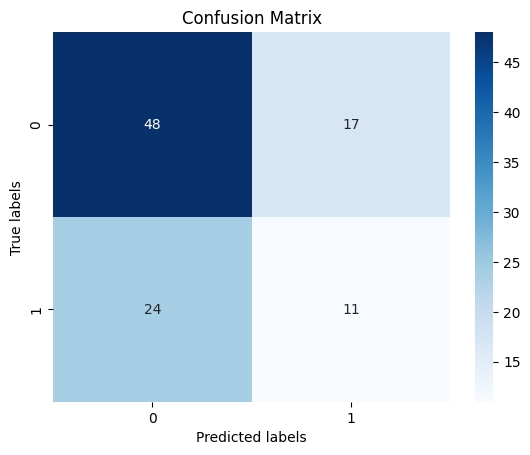

In [14]:
# plot confusion matrix as heatmap
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=labels, yticklabels=labels)

# set plot labels
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")

# show plot
plt.show()

# Machine Learning Predictions and outcomes :

The confusion matrix's values are as follows:

48 (True Positive): The number of samples for which the model's predictions of positivity were accurate.
17 (False Negative): The number of samples that the model predicted as negative but were in fact positive.
24 (False Positive): The number of samples that the model predicted as positive but were actually negative.
11 (True Negative): The number of samples for which the model's prediction of a negative result was accurate.
The confusion matrix demonstrates that, overall, the model correctly predicted 48 positive samples (True Positive) and 11 negative samples (True Negative), but that it incorrectly predicted 17 positive samples as negative (False Negative) and 24 negative samples as positive (False Positive).

The TPOTClassifier is a machine learning tool that automatically searches for the best pipeline to solve a specific classification problem using genetic programming. Each parameter in this snippet of code accomplishes the following:

generations: How many iterations the genetic programming algorithm will go through. It is set to 4 in this instance.
The number of people to include in each generation of the genetic programming algorithm is called the population_size. It is currently set to 15.
cv: How many cross-validation folds should be used to assess each pipeline. It is set to 4 in this instance.
scoring: The scoring metric to use in assessing each pipeline's performance. It is currently set to "f1," which represents the F1 score.
Random_state: The genetic programming algorithm's random seed. It is currently set to 42.
Verbosity: The amount of information the genetic programming algorithm should print out. Since it is set to 2 in this instance, information regarding the generations and the evaluation pipelines will be printed.
The number of parallel processing CPU cores to use for the genetic programming algorithm is designated as n_jobs. It is set to -1 in this instance, indicating that all cores will be utilised.


### Based on prototype defined in second assigment

In [5]:
pipeline_optimizer = TPOTClassifier(generations=4, population_size=15, cv=4, scoring='f1',
                                    random_state=42, verbosity=2, n_jobs=-1)

In [6]:
pipeline_optimizer.fit(X_train, y_train)

Optimization Progress:   0%|          | 0/75 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7209030100334448

Generation 2 - Current best internal CV score: 0.7209030100334448

Generation 3 - Current best internal CV score: 0.7209030100334448

Generation 4 - Current best internal CV score: 0.7209030100334448

Best pipeline: DecisionTreeClassifier(input_matrix, criterion=gini, max_depth=4, min_samples_leaf=19, min_samples_split=20)


TPOTClassifier(cv=4, generations=4, n_jobs=-1, population_size=15,
               random_state=42, scoring='f1', verbosity=2)

In order to find the ideal hyperparameters to use in the TPOTClassifier pipeline optimizer, this code creates a GridSearchCV object. Each parameter's function in the param_grid dictionary is as follows:

generations: How many iterations the genetic programming algorithm will go through. The grid search will be used to fine-tune this parameter.
The number of people to include in each generation of the genetic programming algorithm is called the population_size. The grid search will be used to fine-tune this parameter.
crossover_rate: The likelihood that a genetic programming algorithm will perform a crossover between two individuals. The grid search will be used to fine-tune this parameter.
mutation_rate: The likelihood that a person will undergo a mutation as part of the genetic programming algorithm. The grid search will be used to fine-tune this parameter.

The following parameters are input into the GridSearchCV object:

the TPOTClassifier pipeline optimizer, pipeline_optimizer.
The list of available hyperparameters is in param_grid.
Cross-validation folds (cv): The number of folds to use when assessing each pipeline during a grid search.
scoring: The scoring metric to use when assessing each pipeline's performance during the grid search.
N_jobs: The number of parallel processing CPU cores to use during the grid search. It is set to -1 in this instance, indicating that all cores will be utilised.
In order to enhance the performance of the classification model, this code's overall goal is to conduct a grid search to identify the best hyperparameters to use in the TPOTClassifier pipeline optimizer.

In [ ]:
#This cell took a lot of time to execute and even lead our systems to crash, so we ran the simple optimizer shown in above cells
'''
pipeline_optimizer = TPOTClassifier(
    generations=5,
    population_size=20,
    cv=5,
    scoring='f1',
    random_state=42,
    verbosity=2,
    n_jobs=-1
)

# Define the hyperparameter search space
param_grid = {
    'generations': [5, 10],
    'population_size': [20, 30],
    'crossover_rate': [0.1, 0.3],
    'mutation_rate': [0.1, 0.3]
}

# Create a grid search object
grid_search = GridSearchCV(
    pipeline_optimizer,
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)
'''

In [7]:
print(pipeline_optimizer.score(X_test, y_test))

0.15384615384615383


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_scorer.py:794: FutureWarning: sklearn.metrics.SCORERS is deprecated and will be removed in v1.3. Please use sklearn.metrics.get_scorer_names to get a list of available scorers and sklearn.metrics.get_metric to get scorer.
  warnings.warn(


In [9]:
y_pred = pipeline_optimizer.predict(X_test)


In [10]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.67      0.98      0.80        65
        True       0.75      0.09      0.15        35

    accuracy                           0.67       100
   macro avg       0.71      0.54      0.47       100
weighted avg       0.70      0.67      0.57       100



In [11]:
accuracy_score(y_test, y_pred)

0.67


#### As seen above the accuracy score for TPOT classifier is much higher than the gridserach model that we fit the data with.

In [13]:
cm = confusion_matrix(y_test, y_pred, labels=[False, True])

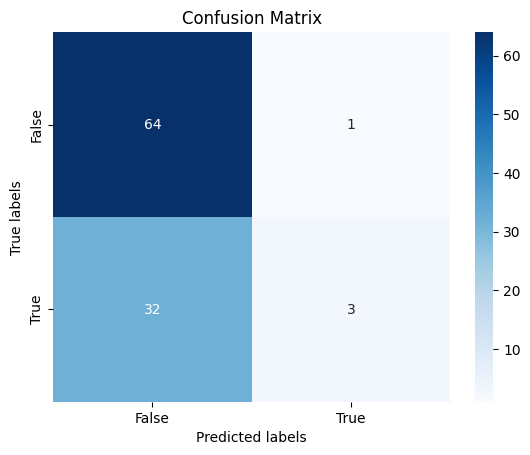

In [18]:
# plot confusion matrix as heatmap
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=[False, True], yticklabels=[False, True])

# set plot labels
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")

# show plot
plt.show()

The matrix reveals the following:

It was correctly predicted that 64 situations would be negative, and they were.
One occurrence that was expected to be negative turned out to be positive.
32 instances that were expected to be positive turned out to be negative.
Three occurrences that were predicted to be positive turned out to be so.
In conclusion, the performance of a binary classification model on a test set of 100 instances is represented by this confusion matrix. A total of 67 instances—64 true negatives and 3 true positives—were correctly predicted by the model, while 33 instances—32 false negatives and 1 false positive—were incorrectly predicted.

## Match with the research papers :
The papers we studied were focussed on finding the best strategies to find the model that gives better accuracies when it comes to predicting stock market or recession. Finding the best machine learning model to forecast stock prices in a bear market brought on by the Covid epidemic is the stated problem. The goal is to understand the current recession and the market's current profitability using this model. Collecting pertinent data, such as historical stock prices, economic indicators, and Covid-related statistics, is the first step in achieving this goal. To make the data suitable for machine learning algorithms, it must first be cleaned, processed, and transformed. The next step is to choose and train various machine learning models using the prepared data, including neural networks, decision trees, random forests, and linear regression. Metrics like mean squared should be used to gauge each model's effectiveness.

### References:
<ul>
    <li>https://github.com/Lindstaedt/Stock-recommendation-with-ML </li>
    <li>https://scikit-learn.org/stable/</li>
    <li>https://pandas.pydata.org/docs/</li>
    <li>Adewumi, A. O. & Akinyelu, A. A. (2017). A survey of machine-learning and nature-inspired based credit card fraud detection techniques. International Journal of System Assurance Engineering and Management, 8(2), 937-953. https://doi.org/10.1007/s13198-016-0551-y©​</li>
<li>
Dhar, V. (2013). Data science and prediction. Communications of the ACM, 56(12), 64-7​</li>
<li>
https://doi.org/10.1145/2500499[3) Domingos, P. (2012). A few useful things to know about machine learning.Communications of the ACM, 55(10), 78-87.​</li>
<li>
https://doi.org/10.1145/2347736.2347755​</li>
<li>
“Predicting US Recessions: Financial Variables as Leading Indicators" by T. J. Bond, R. F.GSullivan, and J. M. Willmore, The Review of Economics and Statistics (1998)[5) A policy-making model for evolutionary SME behavior during a pandemic recession supported on game theory approach Ashkan Hafezalkotob a 3, Lia. Nersesian b 1, Keyvan Fardi (2023) https://www.sciencedirect.com/science/article/pii/503608352220096397 via%3 Dihub​</li>
<li>
"Machine Learning Approaches to Recession Prediction* by H. James and J. W. Popper, Journal of Banking & Finance (2003)171 https://www.kaggle.com/code/rodsaldanha/stock-prediction-pytorch/notebook​</li>
</ul>

Improvements with code visualization :
1) We will plot the preditions across latest years of data and compare both the models - Romana Hussain
2) Performance of stocks in different time periods of recession are strong indicators, we can use these indicators to predict recession - Abhinav Sharma
3) We can visualize the underlying causes of the recession and focus on those causes to prevent recessions in the future. - Atyender Pal Singh